In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import seaborn as sns
import scipy.stats
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [2]:
bureau = pd.read_csv("D:\\NEU\\Kì 5\\visualization\\final\\dseb-63-data-preparation-final-project\\dseb63_final_project_DP_dataset\\dseb63_final_project_DP_dataset\\dseb63_bureau.csv")
print(bureau.shape)
bureau.head()

(1465325, 17)


,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR
0,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,254629
1,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,254629
2,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,254629
3,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,254629
4,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,254629


In [3]:
bureau_bal = pd.read_csv("C:\\Users\\HI\\Downloads\\dseb-63-data-preparation-final-project\\dseb63_final_project_DP_dataset\\dseb63_final_project_DP_dataset\\dseb63_bureau_balance.csv")
print(bureau_bal.shape)
bureau_bal.head()

(27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


### FUNCTION

In [4]:
##### FUNCTION FOR COUNTING MISSINGS
def count_missings(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum() / data.isnull().count() * 100).sort_values(ascending = False)
    table = pd.concat([total, percent], axis = 1, keys = ["Total", "Percent"])
    table = table[table["Total"] > 0]
    return table

In [5]:
### FUNCTION FOR DATA TYPE
def dtype (df):
    sum_dtype = pd.DataFrame (df.dtypes).sort_values(0)\
        .rename(columns={0: "Data Type"})
    return sum_dtype

In [6]:
##### FUNCTION FOR CONVERTING DATES
def convert_days(data, features, t = 12, rounding = True, replace = False):
    for var in features:
        if replace == True:
            if rounding == True:
                data[var] = round(-data[var]/t)
            else:
                data[var] = -data[var]/t
            data[var][data[var] < 0] = None
        else:
            if rounding == True:
                data["CONVERTED_" + str(var)] = round(-data[var]/t)
            else:
                data["CONVERTED_" + str(var)] = -data[var]/t
            data["CONVERTED_" + str(var)][data["CONVERTED_" + str(var)] < 0] = None
    return data

In [7]:
##### FUNCTION FOR CREATING LOGARITHMS
def create_logs(data, features, replace = False):
    for var in features:
        if replace == True:
            data[var] = np.log(data[var].abs() + 1)
        else:
            data["LOG_" + str(var)] = np.log(data[var].abs() + 1)      
    return data

In [8]:
# CHECK OUTLIERS
def find_outlier_columns(data, method):
    outlier_columns = []

    # Loop through numerical columns
    for column in data.select_dtypes(include='number').columns:
        if method == 'iqr':
            # Using the Interquartile Range (IQR) method to detect outliers
            Q1 = data[column].quantile(0.25)  # First quartile (25th percentile)
            Q3 = data[column].quantile(0.75)  # Third quartile (75th percentile)
            IQR = Q3 - Q1  # Interquartile range
            lower_limit = Q1 - 1.5 * IQR
            upper_limit = Q3 + 1.5 * IQR
            # Check if any values fall outside the bounds
            if ((data[column] < lower_limit) | (data[column] > upper_limit)).any():
                outlier_columns.append(column)
        elif method == 'std':
            # Using the Standard Deviation (STD) method to detect outliers
            mean_value = data[column].mean()
            std_dev = data[column].std()
            lower_limit = mean_value - 3 * std_dev
            upper_limit = mean_value + 3 * std_dev
            # Check if any values fall outside the bounds
            if ((data[column] < lower_limit) | (data[column] > upper_limit)).any():
                outlier_columns.append(column)

    return outlier_columns

# Function to create boxplots for columns with outliers
def visualize_outlier_columns(data, method='iqr'):
    outlier_columns = find_outlier_columns(data, method)

    # If no outliers are found, exit the function
    if not outlier_columns:
        print("No outliers detected in any column.")
        return

    # Calculate layout for boxplots
    total_columns = len(outlier_columns)
    rows = (total_columns + 2) // 3  # Arrange plots in rows with 3 plots per row

    # Create subplots
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axes = axes.flatten()

    # Generate a boxplot for each column with outliers
    for idx, column in enumerate(outlier_columns):
        sns.boxplot(x=data[column], ax=axes[idx])
        axes[idx].set_title(f'Boxplot: {column}')
        axes[idx].set_xlabel('Values')

    # Turn off unused axes
    for idx in range(total_columns, len(axes)):
        axes[idx].axis('off')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

In [10]:
# FUNCTION FOR AGGREGATING DATA
def aggregate_data(data, id_var, label=None):
    # Separate numeric and categorical features
    data_factors = [f for f in data.columns if data[f].dtype == "object"]
    num_data = data[list(set(data.columns) - set(data_factors))]
    fac_data = data[[id_var] + data_factors]

    num_facs = fac_data.shape[1] - 1
    num_nums = num_data.shape[1] - 1
    print(f"- Extracted {num_facs} factors and {num_nums} numerics...")

    # Aggregation for numerics
    if num_nums > 0:
        print("- Aggregating numeric features...")
        # Convert all non-numeric columns to numeric (replace non-numeric with NaN)
        for col in num_data.columns:
            if col != id_var:  # Skip the group key
                num_data[col] = pd.to_numeric(num_data[col], errors="coerce")
        # Perform aggregation
        num_data = num_data.groupby(id_var).agg(["mean", "std", "min", "max"])
        num_data.columns = ["_".join(col).strip() for col in num_data.columns.values]
        num_data = num_data.sort_index()

    # Aggregation for factors
    if num_facs > 0:
        print("- Aggregating factor features...")
        fac_data = fac_data.groupby(id_var).agg(
            {
                col: [("mode", lambda x: mode(x, nan_policy='omit').mode[0] if len(x) > 0 else np.nan),
                      ("unique", lambda x: x.nunique())]
                for col in data_factors
            }
        )
        fac_data.columns = ["_".join(col).strip() for col in fac_data.columns.values]
        fac_data = fac_data.sort_index()

    # Merge numeric and factor datasets
    if num_facs > 0 and num_nums > 0:
        agg_data = pd.concat([num_data, fac_data], axis=1)
    elif num_facs > 0:
        agg_data = fac_data
    elif num_nums > 0:
        agg_data = num_data

    # Update column labels
    if label:
        agg_data.columns = [label + "_" + str(col) for col in agg_data.columns]

    print("- Final dimensions:", agg_data.shape)

    return agg_data

### BUREAU BALANCE

In [11]:
bureau_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [12]:
bureau_bal['STATUS'].value_counts()


STATUS
C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: count, dtype: int64

In [13]:
# check missing value
null_data = count_missings(bureau_bal)
null_data

,Total,Percent


In [14]:
#check outliers
visualize_outlier_columns(bureau_bal, method='iqr')

No outliers detected in any column.


In [15]:
# Feature engineering
bureau_bal["NUM_STATUS"] = 0
bureau_bal["NUM_STATUS"][bureau_bal["STATUS"] == "X"] = -1
bureau_bal["NUM_STATUS"][bureau_bal["STATUS"] == "1"] = 1
bureau_bal["NUM_STATUS"][bureau_bal["STATUS"] == "2"] = 2
bureau_bal["NUM_STATUS"][bureau_bal["STATUS"] == "3"] = 3
bureau_bal["NUM_STATUS"][bureau_bal["STATUS"] == "4"] = 4
bureau_bal["NUM_STATUS"][bureau_bal["STATUS"] == "5"] = 5
bureau_bal["LOAN_SCORE"] = bureau_bal["NUM_STATUS"] / (abs(bureau_bal["MONTHS_BALANCE"]) + 1)
loan_score = bureau_bal.groupby("SK_ID_BUREAU", as_index = False).LOAN_SCORE.sum()
del bureau_bal["NUM_STATUS"]
del bureau_bal["LOAN_SCORE"]


C:\Users\HI\AppData\Local\Temp\ipykernel_788\1099901881.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  bureau_bal["NUM_STATUS"][bureau_bal["STATUS"] == "X"] = -1
C:\Users\HI\AppData\Local\Temp\ipykernel_788\1099901881.py:3: SettingWithC

In [16]:
# dummy encoding for STATUS
bureau_bal = pd.get_dummies(bureau_bal, columns = ["STATUS"], prefix = "STATUS")

In [17]:
### AGGREGATIONS

# Total month count
cnt_mon = bureau_bal[["SK_ID_BUREAU", "MONTHS_BALANCE"]].groupby("SK_ID_BUREAU").count()
del bureau_bal["MONTHS_BALANCE"]

# Ensure numeric columns in `bureau_bal` are clean
for col in bureau_bal.columns:
   if col != "SK_ID_BUREAU":  # Skip the group key
      bureau_bal[col] = pd.to_numeric(bureau_bal[col], errors="coerce")

# Aggregate data
agg_bureau_bal = bureau_bal.groupby("SK_ID_BUREAU").mean()
agg_bureau_bal["MONTH_COUNT"] = cnt_mon

# Add loan score
agg_bureau_bal = agg_bureau_bal.merge(loan_score, how="left", on="SK_ID_BUREAU")

In [18]:
agg_bureau_bal.head()

,SK_ID_BUREAU,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTH_COUNT,LOAN_SCORE
0,5001709,0.000000,0.0,0.0,0.0,0.0,0.0,0.886598,0.113402,97,-0.119707
1,5001710,0.060241,0.0,0.0,0.0,0.0,0.0,0.578313,0.361446,83,-0.446638
2,5001711,0.750000,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000,4,-1.000000
3,5001712,0.526316,0.0,0.0,0.0,0.0,0.0,0.473684,0.000000,19,0.000000
4,5001713,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,22,-3.690813


In [19]:
del bureau_bal

### BUREAU

In [20]:
### MERGE
bureau = bureau.merge(right = agg_bureau_bal.reset_index(), how = "left", on = "SK_ID_BUREAU")

In [21]:
bureau.describe()

,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,...,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTH_COUNT,LOAN_SCORE
count,1.465325e+06,1.465325e+06,1.465325e+06,1.376227e+06,920652.000000,5.167800e+05,1.465325e+06,1.465322e+06,1.242231e+06,9.756550e+05,...,523515.000000,523515.000000,523515.000000,523515.000000,523515.000000,523515.000000,523515.000000,523515.000000,523515.000000,523515.000000
mean,5.890328e+06,-1.143600e+03,8.887612e-01,4.931322e+02,-1022.765286,3.942852e+03,7.278249e-03,3.516889e+05,1.358890e+05,6.363687e+03,...,0.435743,0.012598,0.000892,0.000311,0.000204,0.001757,0.345264,0.203231,28.082504,-0.426460
std,5.378271e+05,8.000200e+02,3.824707e+01,4.964905e+03,718.371749,2.196856e+05,1.026408e-01,1.078009e+06,6.756650e+05,4.543915e+04,...,0.347065,0.050529,0.009548,0.004512,0.003442,0.029631,0.367459,0.323516,21.954952,1.317633
min,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-42023.000000,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-5.157072
25%,5.416944e+06,-1.671000e+03,0.000000e+00,-1.144000e+03,-1503.000000,0.000000e+00,0.000000e+00,5.116500e+04,0.000000e+00,0.000000e+00,...,0.121951,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,-0.234788
50%,5.856021e+06,-9.850000e+02,0.000000e+00,-3.340000e+02,-900.000000,0.000000e+00,0.000000e+00,1.246981e+05,0.000000e+00,0.000000e+00,...,0.363636,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.024390,22.000000,-0.011494
75%,6.363543e+06,-4.700000e+02,0.000000e+00,4.730000e+02,-427.000000,0.000000e+00,0.000000e+00,3.082500e+05,3.965400e+04,0.000000e+00,...,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.727273,0.266667,40.000000,0.000000
max,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000,1.159872e+08,9.000000e+00,3.960000e+08,1.701000e+08,4.705600e+06,...,1.000000,1.000000,0.714286,0.400000,0.500000,1.000000,1.000000,1.000000,97.000000,25.243646


In [22]:
bureau.shape

(1465325, 28)

In [23]:
null_data = count_missings(bureau)
null_data

,Total,Percent
AMT_ANNUITY,1130013,77.116885
AMT_CREDIT_MAX_OVERDUE,948545,64.732738
STATUS_X,941810,64.273113
MONTH_COUNT,941810,64.273113
STATUS_2,941810,64.273113
STATUS_3,941810,64.273113
STATUS_4,941810,64.273113
STATUS_5,941810,64.273113
index,941810,64.273113
STATUS_0,941810,64.273113


#### categorical

In [24]:
table_dtype = dtype(bureau)
table_dtype

,Data Type
SK_ID_BUREAU,int64
DAYS_CREDIT,int64
CREDIT_DAY_OVERDUE,int64
CNT_CREDIT_PROLONG,int64
SK_ID_CURR,int64
DAYS_CREDIT_UPDATE,int64
STATUS_X,float64
STATUS_C,float64
STATUS_5,float64
STATUS_4,float64


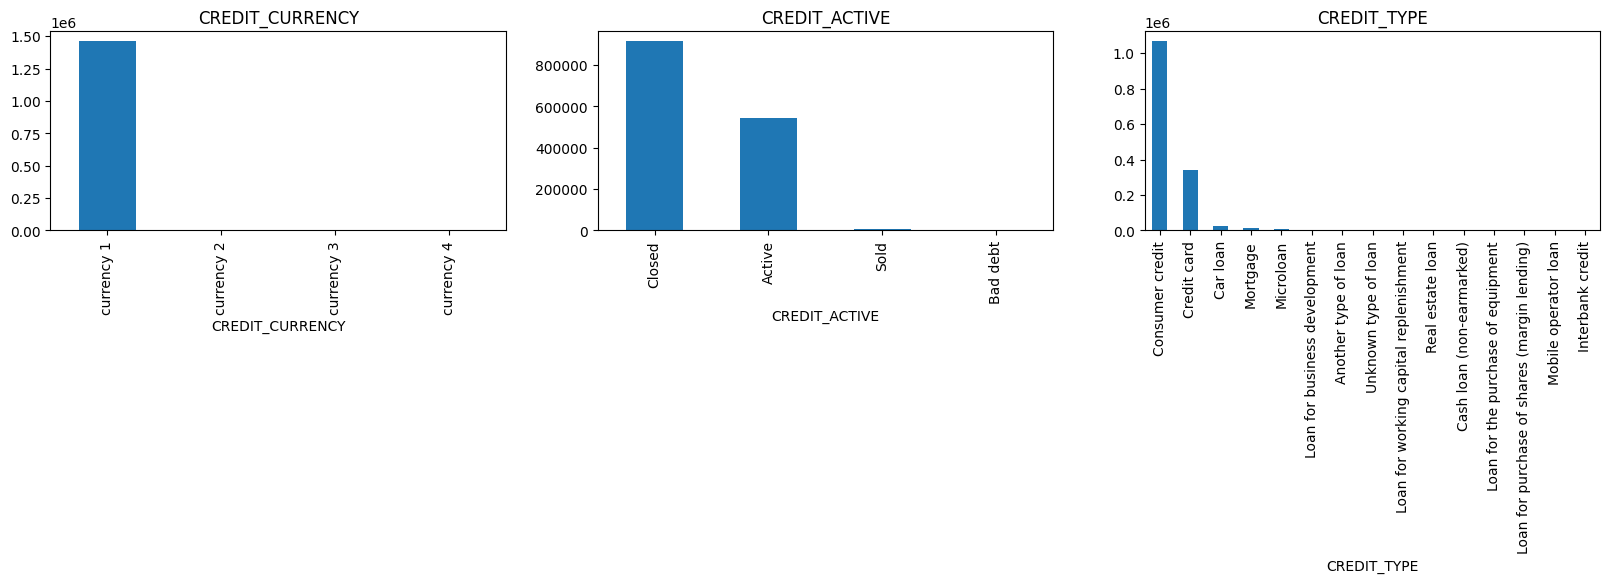

In [25]:
dtypes_object = table_dtype[table_dtype['Data Type'] == 'object'].index.tolist()

def _plot_bar_classes(cols):
    bureau[cols].value_counts().plot.bar()

plt.figure(figsize = (20, 15))    
num_cols = len(dtypes_object)
for i in range(1, num_cols + 1):
    plt.subplot(5, 3, i)
    _plot_bar_classes(dtypes_object[i-1])
    plt.title(dtypes_object[i-1])

##### CREDIT_CURRENCY
It appears that most of the values are categorized under "currency 1" with very few occurrences of other currencies. If the other currencies (currency 2, 3, 4) are not meaningful or underrepresented, we remove them entirely.

##### CREDIT_ACTIVE
The majority of the records are either "Closed" or "Active," with very few entries under "Sold" and "Bad debt." It may be useful to either remove these minor categories or combine them into a broader category like "Other."

##### CREDIT_TYPE
"Consumer credit" and "Credit card" dominate the dataset, while many other types of credit (e.g., "Loan for business development," "Microloan," etc.) are very rare. These less frequent categories might be consolidated into an "Other" category to reduce the number of unique values.

In [26]:
def clean_categorical_data(df):
    # Clean CREDIT_CURRENCY - Combine infrequent categories
    currency_counts = df['CREDIT_CURRENCY'].value_counts()
    if len(currency_counts) > 1:
        # Combine all currencies except 'currency 1' into 'Other'
        df['CREDIT_CURRENCY'] = df['CREDIT_CURRENCY'].apply(lambda x: x if x == 'currency 1' else 'Other')

    # Clean CREDIT_ACTIVE - Combine 'Sold' and 'Bad debt' into 'Other'
    df['CREDIT_ACTIVE'] = df['CREDIT_ACTIVE'].apply(lambda x: x if x in ['Closed', 'Active'] else 'Other')

    # Clean CREDIT_TYPE - Combine infrequent types into 'Other'
    credit_type_counts = df['CREDIT_TYPE'].value_counts()
    threshold = 0.05 * len(df)  # Example: less than 5% of the data is considered rare
    rare_types = credit_type_counts[credit_type_counts < threshold].index.tolist()
    
    df['CREDIT_TYPE'] = df['CREDIT_TYPE'].apply(lambda x: x if x not in rare_types else 'Other')

    return df

bureau = clean_categorical_data(bureau)


#### outliers

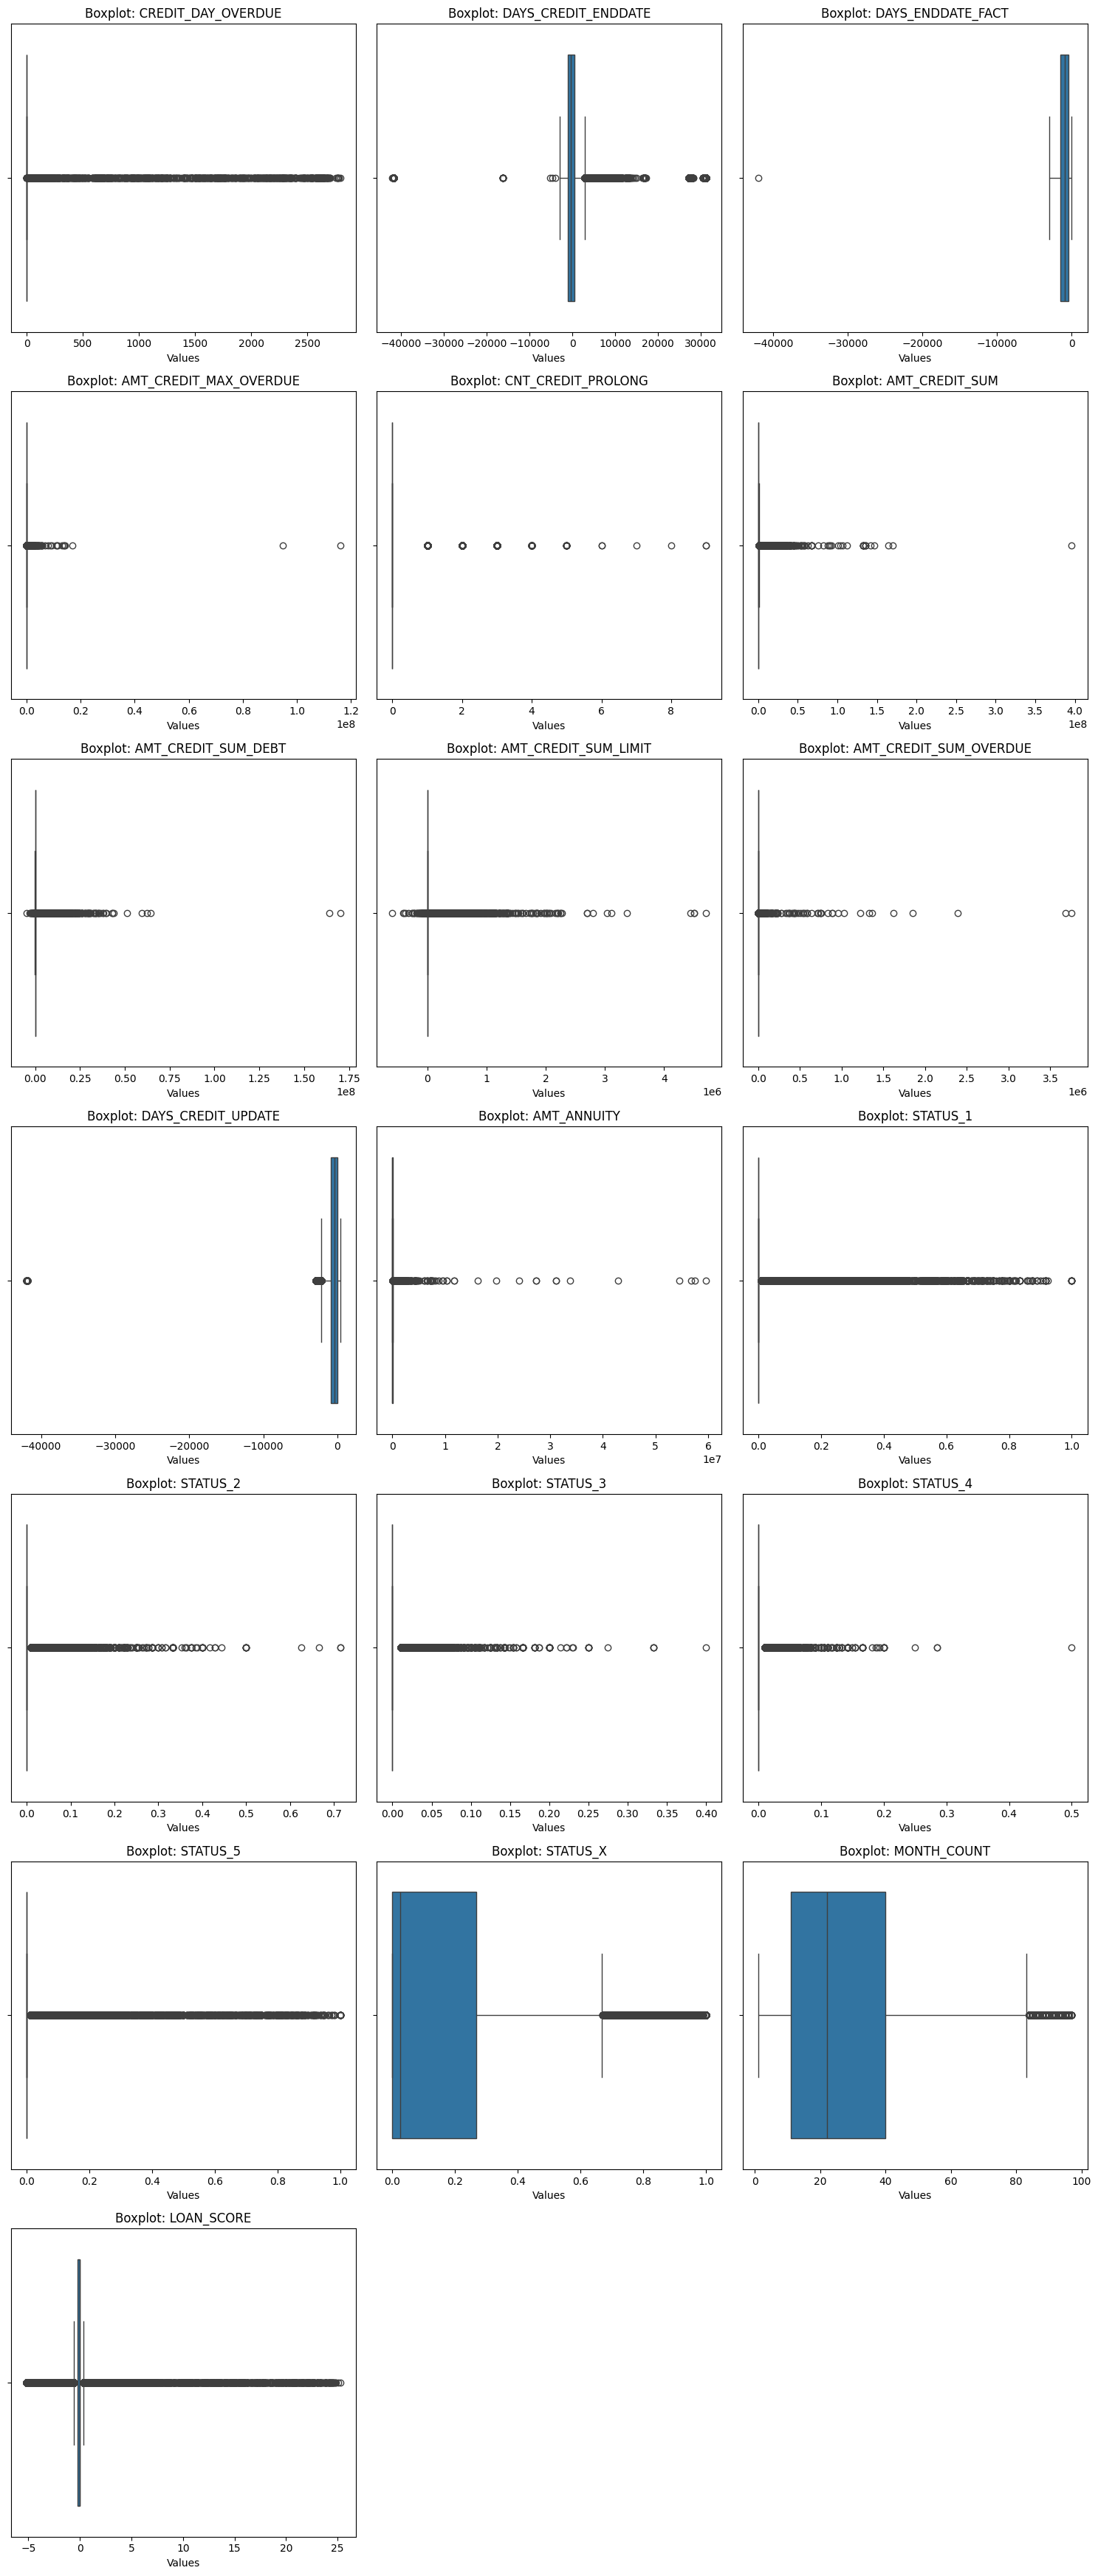

In [27]:
visualize_outlier_columns(bureau, method='iqr')
#1: nhiều giá trị 0 


In [41]:
bureau['DAYS_CREDIT_ENDDATE'].value_counts()

DAYS_CREDIT_ENDDATE
-0.0        746
 7.0        718
 14.0       676
 16.0       660
 6.0        658
           ... 
 5150.0       1
 16301.0      1
 41905.0      1
 41910.0      1
 41938.0      1
Name: count, Length: 2920, dtype: int64

In [42]:
bureau['DAYS_ENDDATE_FACT'].value_counts()

DAYS_ENDDATE_FACT
329.0     695
273.0     692
925.0     681
91.0      680
924.0     680
         ... 
3042.0      1
2906.0      1
2862.0      1
2894.0      1
2922.0      1
Name: count, Length: 2916, dtype: int64

In [43]:
bureau['AMT_CREDIT_MAX_OVERDUE'].value_counts()

AMT_CREDIT_MAX_OVERDUE
0.000        409643
1440.000        590
225.000         370
45.000          346
4.500           269
              ...  
9140.400          1
50908.680         1
28548.000         1
9940.545          1
13118.805         1
Name: count, Length: 61066, dtype: int64

In [44]:
bureau['AMT_CREDIT_SUM'].value_counts()

AMT_CREDIT_SUM
0.000000     55928
12.323860    49999
11.813037    43991
11.407576    31886
13.017005    31590
             ...  
14.099487        1
12.458373        1
12.630233        1
11.023239        1
10.844707        1
Name: count, Length: 211528, dtype: int64

In [45]:
bureau['AMT_CREDIT_SUM_LIMIT'].value_counts()

AMT_CREDIT_SUM_LIMIT
0.000000     910424
11.813037      1991
8.412055       1411
10.714440      1150
11.407576       860
              ...  
11.207778         1
10.990438         1
7.769953          1
8.254784          1
8.438087          1
Name: count, Length: 45256, dtype: int64

In [46]:
bureau['AMT_CREDIT_SUM_OVERDUE'].value_counts()

AMT_CREDIT_SUM_OVERDUE
0.000000     1461681
1.704748         277
2.302585         101
2.674149          68
2.944439          61
              ...   
9.801676           1
10.403839          1
4.381714           1
6.306968           1
9.348797           1
Name: count, Length: 1440, dtype: int64

In [47]:
bureau['AMT_CREDIT_SUM_DEBT'].value_counts()

AMT_CREDIT_SUM_DEBT
0.000000     864650
1.704748        612
6.111467        605
11.813037       314
11.407576       265
              ...  
15.642841         1
9.338015          1
11.397825         1
10.647917         1
11.170694         1
Name: count, Length: 202621, dtype: int64

In [48]:
bureau['DAYS_CREDIT_UPDATE'].value_counts()

DAYS_CREDIT_UPDATE
7.0        15675
8.0        15627
10.0       14724
11.0       14338
9.0        14283
           ...  
41917.0        1
41861.0        1
41914.0        1
41853.0        1
41918.0        1
Name: count, Length: 2968, dtype: int64

In [28]:
#bureau = remove_outliers(bureau, method='IQR', threshold=1.5)

In [29]:
bureau.shape

(1465325, 28)

#### feature engineering

In [30]:
##### FEATURE ENGINEERING

# number of bureau loans 
cnt_bureau = bureau[["SK_ID_CURR", "SK_ID_BUREAU"]].groupby(["SK_ID_CURR"], as_index = False).count()
cnt_bureau.columns = ["SK_ID_CURR", "CNT_BUREAU_LOANS"]
bureau = bureau.merge(cnt_bureau, how = "left", on = "SK_ID_CURR")

# amount ratios
bureau["AMT_SUM_OVERDUE_RATIO_1"] = bureau["AMT_CREDIT_SUM_OVERDUE"] / bureau["AMT_ANNUITY"]
bureau["AMT_SUM_OVERDUE_RATIO_2"] = bureau["AMT_CREDIT_SUM_OVERDUE"] / bureau["AMT_CREDIT_SUM"]
bureau["AMT_MAX_OVERDUE_RATIO_1"] = bureau["AMT_CREDIT_MAX_OVERDUE"] / bureau["AMT_ANNUITY"]
bureau["AMT_MAX_OVERDUE_RATIO_2"] = bureau["AMT_CREDIT_MAX_OVERDUE"] / bureau["AMT_CREDIT_SUM"]
bureau["AMT_SUM_DEBT_RATIO_1"]    = bureau["AMT_CREDIT_SUM_DEBT"] / bureau["AMT_CREDIT_SUM"]
bureau["AMT_SUM_DEBT_RATIO_2"]    = bureau["AMT_CREDIT_SUM_DEBT"] / bureau["AMT_CREDIT_SUM_LIMIT"]

# logarithms
log_vars = ["AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE", "AMT_ANNUITY"]
bureau = create_logs(bureau, log_vars, replace = True)

# convert days
day_vars = ["DAYS_CREDIT", "CREDIT_DAY_OVERDUE", "DAYS_CREDIT_ENDDATE", "DAYS_ENDDATE_FACT", "DAYS_CREDIT_UPDATE"]
bureau = convert_days(bureau, day_vars, t = 1, rounding = False, replace = True)

# recency-weighted loan score
bureau["WEIGHTED_LOAN_SCORE"] = bureau["LOAN_SCORE"] / (bureau["DAYS_CREDIT"] / 12)

# day differences
bureau["DAYS_END_DIFF_1"] = bureau["DAYS_ENDDATE_FACT"]   - bureau["DAYS_CREDIT_ENDDATE"]
bureau["DAYS_END_DIFF_2"] = bureau["DAYS_CREDIT_UPDATE"]  - bureau["DAYS_CREDIT_ENDDATE"]
bureau["DAYS_DURATION_1"] = bureau["DAYS_CREDIT_ENDDATE"] - bureau["DAYS_CREDIT"]
bureau["DAYS_DURATION_2"] = bureau["DAYS_ENDDATE_FACT"]   - bureau["DAYS_CREDIT"]

# number of active buro loans
cnt_bureau = bureau[["SK_ID_CURR", "CREDIT_ACTIVE"]]
cnt_bureau.columns = ["SK_ID_CURR", "CNT_BUREAU_ACTIVE"]
cnt_bureau = cnt_bureau[cnt_bureau["CNT_BUREAU_ACTIVE"] == "Active"]
cnt_bureau = cnt_bureau[["SK_ID_CURR", "CNT_BUREAU_ACTIVE"]].groupby(["SK_ID_CURR"], as_index = False).count()
bureau = bureau.merge(cnt_bureau, how = "left", on = "SK_ID_CURR")
bureau["CNT_BUREAU_ACTIVE"].fillna(0, inplace = True)

# number of closed buro loans
cnt_bureau = bureau[["SK_ID_CURR", "CREDIT_ACTIVE"]]
cnt_bureau.columns = ["SK_ID_CURR", "CNT_BUREAU_CLOSED"]
cnt_bureau = cnt_bureau[cnt_bureau["CNT_BUREAU_CLOSED"] == "Closed"]
cnt_bureau = cnt_bureau[["SK_ID_CURR", "CNT_BUREAU_CLOSED"]].groupby(["SK_ID_CURR"], as_index = False).count()
bureau = bureau.merge(cnt_bureau, how = "left", on = "SK_ID_CURR")
bureau["CNT_BUREAU_CLOSED"].fillna(0, inplace = True)

# number of defaulted bureau loans
cnt_bureau = bureau[["SK_ID_CURR", "CREDIT_ACTIVE"]]
cnt_bureau.columns = ["SK_ID_CURR", "CNT_BUREAU_BAD"]
cnt_bureau = cnt_bureau[cnt_bureau["CNT_BUREAU_BAD"] == "Bad debt"]
cnt_bureau = cnt_bureau[["SK_ID_CURR", "CNT_BUREAU_BAD"]].groupby(["SK_ID_CURR"], as_index = False).count()
bureau = bureau.merge(cnt_bureau, how = "left", on = "SK_ID_CURR")
bureau["CNT_BUREAU_BAD"].fillna(0, inplace = True)
#Chỉnh warning

C:\Users\HI\AppData\Local\Temp\ipykernel_788\2768025918.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data[var][data[var] < 0] = None
C:\Users\HI\AppData\Local\Temp\ipykernel_788\2768025918.py:9: SettingWithCopyWarning: 
A value is try

In [ ]:
bureau = pd.get_dummies(bureau, drop_first = False)

In [32]:
bureau.shape

(1465325, 45)

In [33]:
# Count previous buro loans
cnt_bureau = bureau[["SK_ID_CURR", "SK_ID_BUREAU"]].groupby("SK_ID_CURR").count()

# Ensure SK_ID_BUREAU is still used for aggregations before deleting
# Perform aggregation
agg_bureau = aggregate_data(bureau, id_var="SK_ID_CURR", label="bureau")

# Add buro loan count to aggregated data
agg_bureau["buro_BURO_COUNT"] = cnt_bureau

# Clean up unwanted variables
omits = ["WEIGHTED_LOAN_SCORE"]
for var in omits:
    std_col = "bureau_" + str(var) + "_std"
    min_col = "bureau_" + str(var) + "_min"
    max_col = "bureau_" + str(var) + "_max"

    if std_col in agg_bureau:
        del agg_bureau[std_col]
    if min_col in agg_bureau:
        del agg_bureau[min_col]
    if max_col in agg_bureau:
        del agg_bureau[max_col]


- Extracted 0 factors and 44 numerics...
- Aggregating numeric features...
- Final dimensions: (263491, 176)


In [34]:
bureau.columns

Index(['SK_ID_BUREAU', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY', 'SK_ID_CURR', 'index', 'STATUS_0', 'STATUS_1',
       'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5', 'STATUS_C', 'STATUS_X',
       'MONTH_COUNT', 'LOAN_SCORE', 'CNT_BUREAU_LOANS',
       'AMT_SUM_OVERDUE_RATIO_1', 'AMT_SUM_OVERDUE_RATIO_2',
       'AMT_MAX_OVERDUE_RATIO_1', 'AMT_MAX_OVERDUE_RATIO_2',
       'AMT_SUM_DEBT_RATIO_1', 'AMT_SUM_DEBT_RATIO_2', 'WEIGHTED_LOAN_SCORE',
       'DAYS_END_DIFF_1', 'DAYS_END_DIFF_2', 'DAYS_DURATION_1',
       'DAYS_DURATION_2', 'CNT_BUREAU_ACTIVE', 'CNT_BUREAU_CLOSED',
       'CNT_BUREAU_BAD', 'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Other',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_TYPE_Credit card',
       'CREDIT_TYPE_Other'],
      dtype='

In [35]:
nas = count_missings(bureau)
nas.head()

,Total,Percent
AMT_MAX_OVERDUE_RATIO_1,1403790,95.800590
AMT_SUM_OVERDUE_RATIO_1,1296975,88.511081
AMT_SUM_DEBT_RATIO_2,1135898,77.518503
AMT_ANNUITY,1130013,77.116885
AMT_MAX_OVERDUE_RATIO_2,971919,66.327879


In [56]:
bureau['AMT_MAX_OVERDUE_RATIO_1'].value_counts()

AMT_MAX_OVERDUE_RATIO_1
0.000000    42884
inf          7099
1.000000       77
0.166667        5
0.050000        5
            ...  
0.206855        1
0.018973        1
0.774507        1
0.221429        1
0.722948        1
Name: count, Length: 11383, dtype: int64

In [36]:
bureau['AMT_ANNUITY'].value_counts()

AMT_ANNUITY
0.000000     167286
8.412055       3971
9.510519       2465
10.021315      2043
9.798183       1350
              ...  
11.471536         1
10.525823         1
8.183114          1
8.903819          1
9.637102          1
Name: count, Length: 30103, dtype: int64

In [37]:
bureau.shape

(1465325, 45)

In [38]:
agg_bureau.shape

(263491, 174)

In [39]:
agg_bureau.to_csv('agg_bureau.csv', index=False)

In [40]:
bureau.to_csv('bureau.csv', index=False)